<h1>Load Dataset</h1>

In [ ]:
import pandas as pd
import json
import os

csv_path = os.path.join('../data', 'spotify_dataset.csv')
json1_path = os.path.join('../data', '900k Definitive Spotify Dataset.json')
json2_path = os.path.join('../data', 'final_milliondataset_BERT_500K_revised.json')

try:
    df_csv = pd.read_csv(csv_path, low_memory=False)
    print(f"CSV loaded with {len(df_csv)} rows and {len(df_csv.columns)} columns\n")
except Exception as e:
    print(f"Error loading CSV: {e}")

print("CSV dataset info:")
display(df_csv.info())
print("\nCSV dataset sample:")
display(df_csv.head())

print("\nLoading first JSON dataset sample (first 1000 records)...")
try:
    with open(json1_path, 'r', encoding='utf-8') as f:
        data_json1 = []
        for i, line in enumerate(f):
            if i >= 1000:
                break
            data_json1.append(json.loads(line))
    print(f"Loaded {len(data_json1)} JSON records from first file\n")
except Exception as e:
    print(f"Error loading JSON 1: {e}")

if len(data_json1) > 0:
    print("Keys in one JSON record:")
    display(data_json1[0].keys())
    print("\nSample JSON record:")
    display(data_json1[0])

try:
    with open(json2_path, 'r', encoding='utf-8') as f:
        data_json2 = []
        for i, line in enumerate(f):
            if i >= 1000:
                break
            data_json2.append(json.loads(line))
    print(f"Loaded {len(data_json2)} JSON records from first file\n")
except Exception as e:
    print(f"Error loading JSON 1: {e}")

if len(data_json2) > 0:
    print("Keys in one JSON record:")
    display(data_json2[0].keys())
    print("\nSample JSON record:")
    display(data_json2[0])


<h1>Dataset Cleaning and Preprocessing</h1>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#Convert to dataframes
df_json1 = pd.DataFrame(data_json1)
df_json2 = pd.DataFrame(data_json2)

#Standardize column names
def clean_col(df):
    df.columns = (df.columns.
                  str.strip().
                  str.lower().
                  str.replace(" ", "_").
                  str.replace("(", "").
                  str.replace(")", "").
                  str.replace("/", "_")
    )
    return df

df_csv = clean_col(df_csv)
df_json1 = clean_col(df_json1)
df_json2 = clean_col(df_json2)

#Columns that all 3 share and will be used for regression
common_cols = [
    "text", "emotion", "genre", "key", "tempo", "loudness_db", "time_signature", "explicit", "popularity", "energy", "danceability", 
    "positiveness", "speechiness", "liveness", "acousticness", "instrumentalness"
]

#Keep only available columns
df_csv = df_csv[[c for c in common_cols if c in df_csv.columns]]
df_json1 = df_json1[[c for c in common_cols if c in df_json1.columns]]
df_json2 = df_json2[[c for c in common_cols if c in df_json2.columns]]

#Merge the three datasets
df = pd.concat([df_csv, df_json1, df_json2], ignore_index=True)
print(f"Merged dataset size: {df.shape}")


#Clean numeric columns and convert types
numeric_cols = [
    "tempo", "loudness_db", "popularity", "energy", "danceability", "positiveness", "speechiness", "liveness", "acousticness", "instrumentalness"
]

#Keep only the db value, remove unit
if "loudness_db" in df.columns:
    df["loudness_db"] = (
        df["loudness_db"]
        .astype(str)            
        .str.replace("db", "")  #remove 'db'
        .str.strip()            #remove extra spaces
    )
    df["loudness_db"] = pd.to_numeric(df["loudness_db"], errors="coerce")

#Convert all the columns into numeric
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

#Map explicit to 1 or 0
df["explicit"] = df["explicit"].map({"Yes": 1, "No": 0})

#Drop rows missing emotion label - target
df = df[df["emotion"].notna()]
# Normalize emotion labels
df['emotion'] = df['emotion'].str.lower().str.strip()
#Keep only joy, sadness, anger
keep_emotions = ['joy', 'sadness', 'anger']
df = df[df['emotion'].isin(keep_emotions)]
print(df['emotion'].value_counts())


#Drop rows missing >30% numeric features
df.dropna(subset=numeric_cols, thresh=7, inplace=True)

print("After cleaning:")
display(df.head())
#Data exploration
display(df.describe())
print(df["emotion"].value_counts())
print(df["genre"].value_counts().head(20))


#Emotion Distribution
plt.figure(figsize=(12,8))
sns.countplot(data=df, x="emotion", order=df["emotion"].value_counts().index)
plt.title("Emotion Distribution")
plt.show()

#Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), annot=True)
plt.title("Correlation Heatmap")
plt.show()

for col in numeric_cols:
    plt.figure(figsize=(12,8))
    
    #Boxplot
    plt.subplot(1,2,1)
    sns.boxplot(x=df[col])
    plt.title(f"{col} - Boxplot")
    
    #Histogram
    plt.subplot(1,2,2)
    #https://seaborn.pydata.org/generated/seaborn.histplot.html
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} - Histogram")
    plt.show()

#Find and display outliers
def detect_outliers(col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return df[(df[col] < lower) | (df[col] > upper)][col]

for col in numeric_cols:
    outliers = detect_outliers(col)
    print(f"{col}: {len(outliers)} outliers")
    #TODO - Could cap outliers with winsorization if needed


#Sample 150,000 rows, 50k from each emotion
#Using https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
TARGET_SIZE = 150000
SAMPLES_PER_EMOTION = 50000

df_sampled_list = []
for emotion, group in df.groupby("emotion"):
    df_sampled_list.append(group.sample(SAMPLES_PER_EMOTION, random_state=37)
)

df_sampled = pd.concat(df_sampled_list, ignore_index=True)

print("Sampled dataset size:", df_sampled.shape)
print(df_sampled["emotion"].value_counts())


#Add vader results to dataframe for regression
vader_path = os.path.join('../data', 'vader_sentiment_150k.pkl')

if os.path.exists(vader_path):
    vader_df = pd.read_pickle(vader_path)
    df_sampled = df_sampled.reset_index(drop=True)
    df_sampled['original_index'] = df_sampled.index
    
    df_sampled = df_sampled.merge(vader_df, on='original_index', how='left')
    df_sampled = df_sampled.drop('original_index', axis=1)
    
    print(f"Dataframe after merging VADER: {df_sampled.shape}")
    display(df_sampled[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']].describe())
else:
    print("VADER pickle not found.")

#Encode categorical
#Emotion - label encoding
label_enc = LabelEncoder()
df_sampled["emotion_label"] = label_enc.fit_transform(df_sampled["emotion"])
emotion_mapping = dict(zip(label_enc.transform(label_enc.classes_), label_enc.classes_))
print("Emotion mapping (label : emotion):")
print(emotion_mapping)

#Genre - one hot
#Extract only the 1st genre if a song has multiple
df_sampled['genre'] = df_sampled['genre'].astype(str).str.split(',').str[0].str.strip()
df_sampled['genre'] = df_sampled['genre'].replace(['nan', 'None', ''], 'unknown')
print(f"After extracting first genre: {df_sampled['genre'].nunique()} unique values")
#Take top 20 genres to avoid too many features
top_genres = df_sampled['genre'].value_counts().head(20).index
df_sampled['genre_grouped'] = df_sampled['genre'].apply(lambda x: x if x in top_genres else 'other')
df_sampled = pd.get_dummies(df_sampled, columns=["genre_grouped"], prefix="genre")
df_sampled.drop(columns=["genre"], inplace=True)

#Key - 24 keys in dataset
#One hot encoding
df_sampled["key"] = df_sampled["key"].fillna("unknown").astype(str).str.strip()
df_sampled["key"] = df_sampled["key"].astype(str).str.strip()
df_sampled = pd.get_dummies(df_sampled, columns=["key"], prefix="key")

#Time sig
#One hot encoding
df_sampled["time_signature"] = df_sampled["time_signature"].astype(str)
invalid_ts = ['nan', 'None', '', 'unknown']
df_sampled = df_sampled[~df_sampled["time_signature"].isin(invalid_ts)]
df_sampled = pd.get_dummies(df_sampled, columns=["time_signature"], prefix="ts")

print("Dataframe after encoding:\n")
display(df_sampled)


numeric_cols += ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']
feature_cols = [c for c in df_sampled.columns 
                if c not in ["emotion", "emotion_label", "text"]]
X = df_sampled[feature_cols]
y = df_sampled["emotion_label"]

#TODO - FEATURE SELECTION, IF NEEDED, SHOULD GO HERE

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=37, stratify=y
)

numeric_cols = [
    "tempo", "loudness_db", "popularity", "energy", "danceability", 
    "positiveness", "speechiness", "liveness", "acousticness", 
    "instrumentalness", "vader_neg", "vader_neu", "vader_pos", 
    "vader_compound"
]


scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("X_test shape:", X_test.shape)
print("y_test distribution:\n", y_test.value_counts())

print("Columns present:\n")
print(df_sampled.columns)
print("Number of columns:\n")
print(df_sampled.shape[1])
print("X - features:\n")
display(X)
print("Y - target:\n")
display(y)

<h1>Models</h1>

In [ ]:
# Models

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Baseline Decision Tree - Gini
dt_base = DecisionTreeClassifier(random_state=67, criterion='gini')
dt_base.fit(X_train, y_train)
y_pred_dt_base = dt_base.predict(X_test)

cm_base = confusion_matrix(y_test, y_pred_dt_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=label_enc.classes_)
disp.plot(cmap=plt.cm.Blues) 
plt.title("Decision Tree Base(Gini) Confusion Matrix")
plt.show() 

print("Decision Tree Classifier - Baseline (Gini)")
print(classification_report(y_test, y_pred_dt_base))

Fitting 3 folds for each of 240 candidates, totalling 720 fits
Best parameters from Stage 1 Grid Search:
{'ccp_alpha': 0.0, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters from Stage 2 Grid Search:
{'criterion': 'entropy', 'max_features': None, 'splitter': 'best'}
Fitting 3 folds for each of 160 candidates, totalling 480 fits
Best parameters from Stage 3 Grid Search:
{'class_weight': None, 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.0, 'min_weight_fraction_leaf': 0.0}


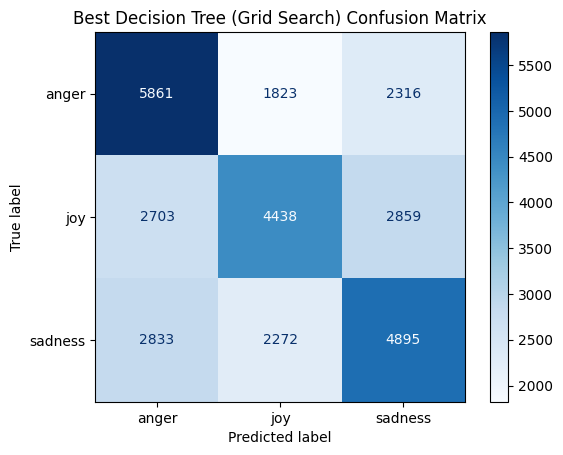

Best Decision Tree Classifier Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 67, 'splitter': 'best'}

Decision Tree Classifier - Best (Grid Search)
              precision    recall  f1-score   support

           0       0.51      0.59      0.55     10000
           1       0.52      0.44      0.48     10000
           2       0.49      0.49      0.49     10000

    accuracy                           0.51     30000
   macro avg       0.51      0.51      0.50     30000
weighted avg       0.51      0.51      0.50     30000



In [ ]:
# Decision Tree Classifier - Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Grid Search for Hyperparameter Tuning

# Stage 1
param_grid_stage_1 = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'ccp_alpha': [0.0, 0.01, 0.05, 0.1]
}

dt_clf = DecisionTreeClassifier(random_state=67)
grid_search_stage_1 = GridSearchCV(estimator=dt_clf, param_grid=param_grid_stage_1, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)
grid_search_stage_1.fit(X_train, y_train)
print("Best parameters from Stage 1 Grid Search:")
print(grid_search_stage_1.best_params_)

# Stage 2
param_grid_stage_2 = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': [None, 'sqrt', 'log2', 5, 10],
    'splitter': ['best', 'random'],
}

dt_clf = DecisionTreeClassifier(random_state=67, **grid_search_stage_1.best_params_)
grid_search_stage_2 = GridSearchCV(estimator=dt_clf, param_grid=param_grid_stage_2, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)
grid_search_stage_2.fit(X_train, y_train)
print("Best parameters from Stage 2 Grid Search:")
print(grid_search_stage_2.best_params_)

# Stage 3
param_grid_stage_3 = {
    'class_weight': [None, 'balanced'],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.05, 0.1],
    'max_leaf_nodes': [None, 10, 20, 30, 50],
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1]
}

dt_clf = DecisionTreeClassifier(random_state=67, **grid_search_stage_1.best_params_, **grid_search_stage_2.best_params_)
grid_search_stage_3 = GridSearchCV(estimator=dt_clf, param_grid=param_grid_stage_3, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)
grid_search_stage_3.fit(X_train, y_train)
print("Best parameters from Stage 3 Grid Search:")
print(grid_search_stage_3.best_params_)

# Best Decision Tree
dt_clf_best = DecisionTreeClassifier(
    random_state=67,
    **grid_search_stage_1.best_params_,
    **grid_search_stage_2.best_params_,
    **grid_search_stage_3.best_params_
)

# Show Best Results
dt_clf_best.fit(X_train, y_train)
y_pred_best = dt_clf_best.predict(X_test)
cm_best = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=label_enc.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Best Decision Tree (Grid Search) Confusion Matrix")
plt.show()  

print(f"Best Decision Tree Classifier Parameters: {format(dt_clf_best.get_params())}\n")
print("Decision Tree Classifier - Best (Grid Search)")
print(classification_report(y_test, y_pred_best))



In [ ]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=67, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=label_enc.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()
print("Random Forest Classifier")
print(classification_report(y_test, y_pred_rf))